# Geospatial Taxi Demand Analysis

To analyze the taxi trip data of Chicago from the year 2015, this notebook will visualize the taxi usage in a geospatial context. Here different h3 maps with different resolutions and heatmaps are used. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap
import h3
from shapely.geometry import Polygon
import geopandas
from geojson import Feature, Point, FeatureCollection, Polygon
from shapely.geometry import Polygon
import plotly.express as px
from datetime import datetime

In [2]:
#Import cleaned dataset

#trips_df = pd.read_parquet('../../data/rides/Taxi_Trips_Sampled_Cleaned.parquet')
trips_df = pd.read_parquet('../../data/rides/Taxi_Trips_Cleaned.parquet')
trips_df.head(3)

taxi_id trip_start_timestamp  trip_end_timestamp  trip_seconds  trip_miles  \
0        1  2015-01-01 00:00:00 2015-01-01 00:00:00         420.0         1.0   
1        2  2015-01-01 00:30:00 2015-01-01 00:30:00         480.0         1.9   
2        3  2015-01-01 00:30:00 2015-01-01 00:45:00         300.0         1.0   

   pickup_census_tract  dropoff_census_tract  pickup_community_area  \
0          17031081500           17031320100                      8   
1          17031081700           17031832600                      8   
2          17031081700           17031842200                      8   

   dropoff_community_area  fare  ...    h3_07_dropoff     h3_08_pickup  \
0                      32  6.05  ...  872664c1effffff  882664c1e1fffff   
1                       7  7.65  ...  872664c13ffffff  882664c1e7fffff   
2                       8  5.25  ...  872664c13ffffff  882664c1e7fffff   

     h3_08_dropoff     h3_09_pickup    h3_09_dropoff  \
0  882664c1e3fffff  892664c1e0fffff  892664c1e2fffff   
1  882664c135fffff  892664c1e73ffff  892664c13cfffff   
2  882664c137fffff  892664c1e73ffff  892664c1377ffff   

                      pickup_centroid                    dropoff_centroid  \
0  POINT (-87.626214906 41.892507781)  POINT (-87.620992913 41.884987192)   
1   POINT (-87.63186395 41.892042136)  POINT (-87.654007029 41.914747305)   
2   POINT (-87.63186395 41.892042136)  POINT (-87.649907226 41.904935302)   

    datetime    temp  precip  
0 2015-01-01 -7.0115       0  
1 2015-01-01 -7.0115       0  
2 2015-01-01 -7.0115       0  

[3 rows x 44 columns]

We create a dictionary for each census tract name of Chicago and add it to our DataFrame to be able to reference to certain locations in our analysis more easily. The census tract list were retrived from [here](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2000/pt6c-hxpp). 

In [3]:
import csv

csv_file = '../../data/census_tract/chicago_census_tract.csv'

# Create an empty dictionary
data_dict = {}

# Open the CSV file
with open(csv_file, 'r') as file:
    reader = csv.reader(file)

    # Skip the header row if present
    next(reader)

    # Iterate over each row in the CSV file
    for row in reader:
        ca = row[1]  # CA is in the second column
        community = row[2]  # COMMUNIT_1 is in the third column

        # Add the data to the dictionary
        data_dict[ca] = community

data_dict = dict(sorted(data_dict.items(), key=lambda item: int(item[0])))
print(data_dict)

{'1': 'Rogers Park', '2': 'West Ridge', '3': 'Uptown', '4': 'Lincoln Square', '5': 'North Center', '6': 'Lake View', '7': 'Lincoln Park', '8': 'Near North Side', '9': 'Edison Park', '10': 'Norwood Park', '11': 'Jefferson Park', '12': 'Forest Glen', '13': 'North Park', '14': 'Albany Park', '15': 'Portage Park', '16': 'Irving Park', '17': 'Dunning', '18': 'Montclare', '19': 'Belmont Cragin', '20': 'Hermosa', '21': 'Avondale', '22': 'Logan Square', '23': 'Humboldt Park', '24': 'West Town', '25': 'Austin', '26': 'West Garfield Park', '27': 'East Garfield Park', '28': 'Near West Side', '29': 'North Lawndale', '30': 'South Lawndale', '31': 'Lower West Side', '32': 'Loop', '33': 'Near South Side', '34': 'Armour Square', '35': 'Douglas', '36': 'Oakland', '37': 'Fuller Park', '38': 'Grand Boulevard', '39': 'Kenwood', '40': 'Washington Park', '41': 'Hyde Park', '42': 'Woodlawn', '43': 'South Shore', '44': 'Chatham', '45': 'Avalon Park', '46': 'South Chicago', '47': 'Burnside', '48': 'Calumet Hei

In [4]:
# Create a new dictionary with integer keys
new_data_dict = {int(key): value for key, value in data_dict.items()}


In [5]:
key_types = [type(key) for key in new_data_dict.keys()]

In [6]:
# Match census tract name to community area unique value
trips_df['pickup_name'] = trips_df['pickup_community_area'].map(new_data_dict)
trips_df['dropoff_name'] = trips_df['dropoff_community_area'].map(new_data_dict)
trips_df.head(3)

taxi_id trip_start_timestamp  trip_end_timestamp  trip_seconds  trip_miles  \
0        1  2015-01-01 00:00:00 2015-01-01 00:00:00         420.0         1.0   
1        2  2015-01-01 00:30:00 2015-01-01 00:30:00         480.0         1.9   
2        3  2015-01-01 00:30:00 2015-01-01 00:45:00         300.0         1.0   

   pickup_census_tract  dropoff_census_tract  pickup_community_area  \
0          17031081500           17031320100                      8   
1          17031081700           17031832600                      8   
2          17031081700           17031842200                      8   

   dropoff_community_area  fare  ...    h3_08_dropoff     h3_09_pickup  \
0                      32  6.05  ...  882664c1e3fffff  892664c1e0fffff   
1                       7  7.65  ...  882664c135fffff  892664c1e73ffff   
2                       8  5.25  ...  882664c137fffff  892664c1e73ffff   

     h3_09_dropoff                     pickup_centroid  \
0  892664c1e2fffff  POINT (-87.626214906 41.892507781)   
1  892664c13cfffff   POINT (-87.63186395 41.892042136)   
2  892664c1377ffff   POINT (-87.63186395 41.892042136)   

                     dropoff_centroid   datetime    temp  precip  \
0  POINT (-87.620992913 41.884987192) 2015-01-01 -7.0115       0   
1  POINT (-87.654007029 41.914747305) 2015-01-01 -7.0115       0   
2  POINT (-87.649907226 41.904935302) 2015-01-01 -7.0115       0   

       pickup_name     dropoff_name  
0  Near North Side             Loop  
1  Near North Side     Lincoln Park  
2  Near North Side  Near North Side  

[3 rows x 46 columns]

In [7]:
#Test for NAN values
trips_df['pickup_name'].isna().sum()

0

## Heatmaps 

In this section, we use heatmaps to visualize the number of starting trips and ending trips. However, due to the size of the heatmaps and kernel failures, we use only a sample of the data. As the size of the heatmap is still too big, we have removed the cell outputs containing the visualization of the heatmaps. So please run through the code for the visualization yourself, either with the sample data, or with enough resource capabilities with the whole dataset. As an alternative we also have [uploaded screenshots]().

#### - Code anpassen mit sampling Datenset und nochmal durchrunnen 
#### - Irgendwo screenshots uploaden 

### Starting Trips

In [8]:
from shapely import wkt

In [9]:
# # Convert the pickup_centroid column to a GeoSeries from WKT format
# trips_df["pickup_centroid"] = geopandas.GeoSeries.from_wkt(trips_df["pickup_centroid"])

In [10]:
# trips_df.set_geometry('pickup_centroid')

In [11]:
#Split pickup_centroid into coordinates
#taken from https://geopandas.org/en/stable/gallery/plotting_with_folium.html 

# geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in trips_df.pickup_centroid]

In [12]:
# # Create DF for starting trip locations and is corresponding area names
# geo_df_pickup = geopandas.GeoDataFrame(geo_df_list, trips_df["pickup_census_tract"])
# geo_df_pickup = geo_df_pickup.reset_index()
# # geo_df_pickup["pickup_name"] = trips_df["pickup_name"]

# geo_df_pickup

In [13]:
# geo_df_pickup = geo_df_pickup.reset_index()
# geo_df_pickup

In [14]:
# # Ploting heatmap that shows the census tracts and the frequency of trips starting there

# trips_heatmap = folium.Map(
#     location=(41.881832, -87.623177), # the orig mean values as location coordinates from https://www.latlong.net/place/chicago-il-usa-1855.html
#     zoom_start=13,
#     control_scale=True,
#     max_zoom=20,
# )

# trips_heatmap.add_child(plugins.HeatMap(geo_df_list, radius=30))

# for _,row in geo_df_pickup.iterrows():
#     popup_content = f"Pickup Name: {row['pickup_name']}<br>Pickup Census Tract: {row['pickup_census_tract']}"
#     folium.CircleMarker(
#         radius=5,
#         location=[row[0], row[1]],
#         popup=folium.Popup(popup_content, parse_html=True),
#         color="crimson",
#         fill_color="crimson",
#     ).add_to(trips_heatmap)
    
    
# trips_heatmap

In the heatmap we can see that the most popular hotspot for Taxis is Loop. Looking more closely into the map, the city center in general is more popular, as well as the airport and other destination that are more far away from the city center. This can also be seen in our **temporal demand patterns**. 
#### - Noch weiter Ausführen

## Ending Trips

In [15]:
# Convert the "dropoff_centroid" column to a GeoSeries from WKT format
# trips_df["dropoff_centroid"] = geopandas.GeoSeries.from_wkt(trips_df["dropoff_centroid"])

In [16]:
# trips_df.set_geometry('dropoff_centroid')

In [17]:
# geo_df_list_dropoff = [[point.xy[1][0], point.xy[0][0]] for point in trips_df.dropoff_centroid]

In [18]:
# geo_df_dropoff = geopandas.GeoDataFrame(geo_df_list_dropoff, trips_df["dropoff_census_tract"])

In [19]:
# geo_df_dropoff = geopandas.GeoDataFrame(geo_df_list, trips_df["dropoff_census_tract"])
# geo_df_dropoff = geo_df_dropoff.reset_index()
# geo_df_dropoff["dropoff_name"] = trips_df["dropoff_name"]

# geo_df_dropoff

In [20]:
# # Ploting heatmap that shows the census tracts and the frequency of trips ending there

# trips_heatmap = folium.Map(
#     location=(41.881832, -87.623177), # the orig mean values as location coordinates from https://www.latlong.net/place/chicago-il-usa-1855.html
#     zoom_start=13,
#     control_scale=True,
#     max_zoom=20,
# )

# trips_heatmap.add_child(plugins.HeatMap(geo_df_list_dropoff, radius=30))

# for _,row in geo_df_dropoff.iterrows():
#     popup_content = f"Dropoff Name: {row['dropoff_name']}<br> </br><br>Dropoff Census Tract: {row['dropoff_census_tract']}"
#     folium.CircleMarker(
#         radius=5,
#         location=[row[0], row[1]],
#         popup=folium.Popup(popup_content, parse_html=True),
#         color="crimson",
#         fill_color="crimson",
#     ).add_to(trips_heatmap)
    
    
# trips_heatmap

The most popular dropoff location is **insert here, when map finally loads**. 

## H3 maps 

We employ h3 maps for additional geospatial visualizations, focusing on resolution types 7, 8, and 9. 
Our approach begins by establishing DataFrames for each resolution type, accompanied by methods for generating hexagonal geometries, counting the number of trips within each hexagon, and designing the visual representation of the h3 maps.

Our Plotly h3 maps are not displayed properly in Jupyter Notebook on GitHub, which is why we will upload static h3 maps instead. If you want to have a look at the dynamic plots, please run the code yourseld. **STATISCH?**

In [21]:
# Creating a dataframe that contains all hexagons where at least one trip started or ended

hexagons7_df = pd.DataFrame()
hexagons8_df = pd.DataFrame()
hexagons9_df = pd.DataFrame()

hexagons7_df["hex"] = pd.concat([trips_df["h3_07_pickup"], trips_df["h3_07_dropoff"]]).unique()
hexagons8_df["hex"] = pd.concat([trips_df["h3_08_pickup"], trips_df["h3_08_dropoff"]]).unique()
hexagons9_df["hex"] = pd.concat([trips_df["h3_09_pickup"], trips_df["h3_09_dropoff"]]).unique()
hexagons7_df.head(3)
hexagons8_df.head(3)
hexagons9_df.head(3)

hex
0  892664c1e0fffff
1  892664c1e73ffff
2  892664c1293ffff

In [22]:
# Defining a funtion that generates heaxagon geometry for each hexagon
# taken from https://medium.com/analytics-vidhya/how-to-create-a-choropleth-map-using-uber-h3-plotly-python-458f51593548

def add_geometry(row):
  points = h3.h3_to_geo_boundary(row['hex'], True)
  return Polygon(points)

In [23]:
#Applying function to our hexagons dataframe

hexagons7_df['geometry'] = (hexagons7_df
                                .apply(add_geometry,axis=1)) 

hexagons8_df['geometry'] = (hexagons8_df
                                .apply(add_geometry,axis=1)) 

hexagons9_df['geometry'] = (hexagons9_df
                                .apply(add_geometry,axis=1)) 


hexagons7_df.head(3)


hex                                           geometry
0  872664c1effffff  POLYGON ((-87.63048927308355 41.90755371098675...
1  872664c12ffffff  POLYGON ((-87.6723729663648 41.93963771855481,...
2  872664c10ffffff  POLYGON ((-87.6427881340186 41.94402243665091,...

In [24]:
# Defining a functions that will count trips for a given groupby value

def calculate_hexagon_trips(hexagons_df, label, group_by):
    hexagons_df[label] = trips_df.groupby(group_by).size()
    hexagons_df[label] = hexagons_df[label].fillna(value=0)

In [25]:
# Calculate starting and ending trips for each hexagon

hexagons7_df = hexagons7_df.set_index('hex')
hexagons8_df = hexagons8_df.set_index('hex')
hexagons9_df = hexagons9_df.set_index('hex')


calculate_hexagon_trips(hexagons7_df, label="starting_trips_07", group_by="h3_07_pickup")
calculate_hexagon_trips(hexagons7_df, label="ending_trips_07", group_by="h3_07_dropoff")
calculate_hexagon_trips(hexagons8_df, label="starting_trips_08", group_by="h3_08_pickup")
calculate_hexagon_trips(hexagons8_df, label="ending_trips_08", group_by="h3_08_dropoff")
calculate_hexagon_trips(hexagons9_df, label="starting_trips_09", group_by="h3_09_pickup")
calculate_hexagon_trips(hexagons9_df, label="ending_trips_09", group_by="h3_09_dropoff")

hexagons7_df = hexagons7_df.reset_index()
hexagons8_df = hexagons8_df.reset_index()
hexagons9_df = hexagons9_df.reset_index()

hexagons9_df.head(3)

hex                                           geometry  \
0  892664c1e0fffff  POLYGON ((-87.62821283343483 41.89422009039776...   
1  892664c1e73ffff  POLYGON ((-87.63243550733023 41.89359528834631...   
2  892664c1293ffff  POLYGON ((-87.6609277473747 41.938599432639094...   

   starting_trips_09  ending_trips_09  
0          1539532.0        1172276.0  
1           998728.0         805638.0  
2            15996.0          32308.0

In [26]:
hexagons7_df["pickup_name"]=trips_df["pickup_name"]
hexagons8_df["pickup_name"]=trips_df["pickup_name"]
hexagons9_df["pickup_name"]=trips_df["pickup_name"]

hexagons7_df

hex                                           geometry  \
0    872664c1effffff  POLYGON ((-87.63048927308355 41.90755371098675...   
1    872664c12ffffff  POLYGON ((-87.6723729663648 41.93963771855481,...   
2    872664c10ffffff  POLYGON ((-87.6427881340186 41.94402243665091,...   
3    872664cacffffff  POLYGON ((-87.68099468459282 41.91921142279649...   
4    872664c14ffffff  POLYGON ((-87.63414405293 41.96445315471353, -...   
..               ...                                                ...   
104  872664cdbffffff  POLYGON ((-87.67848396651723 41.72835644256933...   
105  872664ccdffffff  POLYGON ((-87.560642368785 41.74578433870738, ...   
106  872664561ffffff  POLYGON ((-87.61595940527997 41.68033779584537...   
107  872664c88ffffff  POLYGON ((-87.73633204425838 41.85356815338404...   
108  872664574ffffff  POLYGON ((-87.70792510676493 41.72398203759852...   

     starting_trips_07  ending_trips_07      pickup_name  
0            7532228.0          6705006  Near North Side  
1             122202.0           283480  Near North Side  
2             575439.0           808271  Near North Side  
3             263352.0           363751        Lake View  
4              58437.0            67664     North Center  
..                 ...              ...              ...  
104                0.0                4  Near North Side  
105                0.0                1        West Town  
106                0.0                1        Lake View  
107                0.0                6     Lincoln Park  
108                0.0                2        West Town  

[109 rows x 5 columns]

In [27]:
# Our approach uses the chloropleth_mapbox module of Plotly Express to build a map.
# To do this a GeoJSON-formatted dictionary is created by this method that can be passed to Plotly express. 

# taken from https://medium.com/analytics-vidhya/how-to-create-a-choropleth-map-using-uber-h3-plotly-python-458f51593548

def hexagons_dataframe_to_geojson(df_hex, value_field, file_output = None):

    list_features = []

    for i, row in df_hex.iterrows():
        feature = Feature(geometry = row['geometry'],
                          id = row['hex'],
                          properties = {"value": row[value_field]})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)

    if file_output is not None:
        with open(file_output, "w") as f:
            json.dump(feat_collection, f)

    else :
      return feat_collection

In [28]:
# Function that visualizes the H3 map

# Adapted from https://medium.com/analytics-vidhya/how-to-create-a-choropleth-map-using-uber-h3-plotly-python-458f51593548

def plot_frequency(dataset, variable, labels, range_color, palette="RdBu"):
    geojson_obj = (hexagons_dataframe_to_geojson(dataset, value_field=variable))

    fig = (px.choropleth_mapbox(
                    dataset,
                    width=700,
                    height=500,
                    geojson=geojson_obj, 
                    locations='hex', 
                 #   hover_name = "pickup_name",
                    color=variable,
                    color_continuous_scale=palette,
                    range_color=range_color,
                    mapbox_style='carto-positron',
                    zoom=10.5,
                    center = {"lat": 41.881832 ,"lon": -87.623177,},
                    opacity=0.7,
                    labels=labels))
    fig.update_layout(
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
    )
    return fig 

In [29]:
# Function to plot the frequency with choropleth colors based on the variable

def plot_frequency_test(dataset, hover_name, variable, labels, range_color, palette="RdBu"):
    fig = (px.choropleth_mapbox(
        dataset,
        width=700,
        height=500,
        geojson=hexagons_dataframe_to_geojson(dataset, value_field=variable),
        locations='hex',
        hover_name=hover_name,
        color=variable,  # Use the 'variable' directly as the color
        color_continuous_scale=palette,
        range_color=range_color,
        zoom=10.5,
        center={"lat": 41.881832, "lon": -87.623177},
        opacity=0.7,
        labels=labels,
        animation_frame="month",
       # animation_group="hex",
        mapbox_style="open-street-map",
    ))
    fig.update_layout(
        sliders=[
            dict(
                active=0,
                bgcolor='black'
            )
        ]
    )
    return fig


# Hex7

First we represent the hexagon resolution 7. For each resolution we look at the number of starting trips, the number of ending trips and the demand difference. We will look at the demand difference more in detail by looking at the overall difference, as well as during morning (6am-12pm) and evening (2pm-8pm) hours.

## Starting Trips

In [30]:
variable = "starting_trips_07"

fig = plot_frequency(
    dataset=hexagons7_df,
    variable=variable,
    labels={variable: "Starting Trips in Res7"},
    range_color=(0, hexagons7_df[variable].quantile(0.9)),
    palette="reds",
)

fig.show()

It is visible that the most taxi trips start in the city center, like Loop, Lincoln Park, West Town and Near South Side. These regions are bustling commercial and residential hubs, drawing both locals and visitors for various activities and destinations. As can also be seen in the **POI notebook** is that there are a lot of sustencance, arts and culture and sports POI in these hexagons. 
Furthermore, two other prominent destinations stand out — Airport O'Hare and Clearing. These locations are logical hotspots due to their roles as major transportation hubs, attracting a substantial volume of travelers arriving or departing from the city.

## Ending Trips

In [31]:
variable = "ending_trips_07"

fig = plot_frequency(
    dataset=hexagons7_df,
    variable=variable,
    labels={variable: "Ending Trips in Res7"},
    range_color=(0, hexagons7_df[variable].quantile(0.9)),
    palette="reds"
)

fig.show()

Interestingly, there's a notable similarity between where taxi journeys begin and where they conclude on the map. This similarity suggests a connection between popular starting points and destinations across the city. This can lead to both commencing their journeys and completing them within the central areas. Rather than dispersing to other regions before leaving, many opt to stay within the center. In addition, the prominence of transportation hubs such as Airport O'Hare and Clearing naturally contributes to their dual role as popular starting and ending points. These hubs are central and accessible nodes for incoming and outgoing travel, making their significance self-explanatory.

## Demand Difference

### Overall

In [32]:
# Calculate demand difference
hexagons7_df["demand_difference_07"] = hexagons7_df["starting_trips_07"] - hexagons7_df["ending_trips_07"]
hexagons7_df.head(3)

hex                                           geometry  \
0  872664c1effffff  POLYGON ((-87.63048927308355 41.90755371098675...   
1  872664c12ffffff  POLYGON ((-87.6723729663648 41.93963771855481,...   
2  872664c10ffffff  POLYGON ((-87.6427881340186 41.94402243665091,...   

   starting_trips_07  ending_trips_07      pickup_name  demand_difference_07  
0          7532228.0          6705006  Near North Side              827222.0  
1           122202.0           283480  Near North Side             -161278.0  
2           575439.0           808271  Near North Side             -232832.0

In [33]:
# Ploting a map with hexagons depicting the difference in demand considering starting and ending trips

variable = "demand_difference_07"

fig = plot_frequency(
    dataset=hexagons7_df,
    variable=variable,
    labels={variable: "Demand difference in Res7"},
    range_color=(
        -hexagons7_df[variable].quantile(0.95),
        hexagons7_df[variable].quantile(0.95),
    ),
)
fig.show()

The overall demand difference is only for a few hexagons positive, meaning that in certain parts of these places more taxi trips start than end: Airport O'Hare, Jefferson Park, Loop, Brighton Park and Clearing. Else the demand difference is negative or zero. For places more in the south of Chicago and more on the periphery have a lower demand difference, so the ending trips are not as prominent as the other places. This could be due to reason that outskirts are less habitated than places closer to the city. To look further at the possible reasons why there is a bigger negative demand difference, we will look at different time zones.

### During morning and evening rush hour

### Methoden nach ganz oben bringen?

In [34]:
# Function that returns the number of trips for the given hours and for the given 'group by' value

def calculate_hexagon_trips_by_hours(hexagons_df, label, group_by, hours):
    hexagons_df[label] = (
        trips_df[
            (trips_df["trip_start_timestamp"].dt.hour >= hours[0])
            & (trips_df["trip_start_timestamp"].dt.hour <= hours[1])
        ]
        .groupby(group_by)
        .size()
    )
    hexagons_df[label] = hexagons_df[label].fillna(value=0)

In [35]:
# Function that returns the number of trips for the given hours and for the given 'group by' value

def calculate_hexagon_trips_hour(hexagons_df, hexagon_num):
    hexagon_label = f"h3_0{hexagon_num}"
    #label_prefix = f"hexagon_{hexagon_num}"
    #hexagons_df = hexagons_df.set_index("hex")
    now = datetime.now()
    morning_hours = [now.replace(hour=6).hour, now.replace(hour=12).hour]
    evening_hours = [now.replace(hour=14).hour, now.replace(hour=20).hour]

    calculate_hexagon_trips_by_hours(
        hexagons_df, label="starting_trips_morning", group_by=f"{hexagon_label}_pickup", hours=morning_hours
    )
    calculate_hexagon_trips_by_hours(
        hexagons_df, label= "ending_trips_morning", group_by=f"{hexagon_label}_dropoff", hours=morning_hours
    )
    calculate_hexagon_trips_by_hours(
        hexagons_df, label= "starting_trips_evening", group_by=f"{hexagon_label}_pickup", hours=evening_hours
    )
    calculate_hexagon_trips_by_hours(
        hexagons_df, label= "ending_trips_evening", group_by=f"{hexagon_label}_dropoff", hours=evening_hours
    )

    hexagons_df["trips_difference_morning"] = (
        hexagons_df["starting_trips_morning"] - hexagons_df["ending_trips_morning"]
    )
    hexagons_df["trips_difference_evening"] = (
        hexagons_df["starting_trips_evening"] - hexagons_df["ending_trips_evening"]
    )

    return hexagons_df

In [36]:
# Calculate the difference between starting and ending trips for the morning (06:00-12:00) 
#and for the evening (14:00-20:00) in Resolution 7,8+9
 
hexagon_numbers = [7, 8, 9]
for hexagon_num in hexagon_numbers:
    hexagon_df = globals()[f"hexagons{hexagon_num}_df"]
    hexagon_df = hexagon_df.set_index("hex")
    hexagon_df = calculate_hexagon_trips_hour(hexagon_df, hexagon_num)
    hexagon_df = hexagon_df.reset_index()

    # Optionally, you can assign the updated DataFrame back to its original variable
    globals()[f"hexagons{hexagon_num}_df"] = hexagon_df

hexagons7_df.head(3)


hex                                           geometry  \
0  872664c1effffff  POLYGON ((-87.63048927308355 41.90755371098675...   
1  872664c12ffffff  POLYGON ((-87.6723729663648 41.93963771855481,...   
2  872664c10ffffff  POLYGON ((-87.6427881340186 41.94402243665091,...   

   starting_trips_07  ending_trips_07      pickup_name  demand_difference_07  \
0          7532228.0          6705006  Near North Side              827222.0   
1           122202.0           283480  Near North Side             -161278.0   
2           575439.0           808271  Near North Side             -232832.0   

   starting_trips_morning  ending_trips_morning  starting_trips_evening  \
0               2021698.0             1737991.0               3189688.0   
1                  6240.0               13771.0                 39852.0   
2                142213.0               49264.0                196926.0   

   ending_trips_evening  trips_difference_morning  trips_difference_evening  
0             2998390.0                  283707.0                  191298.0  
1              112164.0                   -7531.0                  -72312.0  
2              350817.0                   92949.0                 -153891.0

In [37]:
# Ploting a map with hexagons depicting the demand difference in the morning

variable = "trips_difference_morning"

fig = plot_frequency(
    dataset=hexagons7_df,
    variable=variable,
    labels={variable: "Demand Difference Morning in Res7"},
    range_color=(
        -hexagons7_df[variable].quantile(0.9),
        hexagons7_df[variable].quantile(0.9),
    ),
)
fig.show()

In the morning (6am-12pm) the overall demand difference in most parts of Chicago is neither high on the positive or negative. **Reason**
The Airport and clearing having more ending trips could be due to the fact that people mostly travel in the morning to go to work, e.g. business trips.
Around Loop, Near North Side, Douglas and Lincoln Park there are also more ending trips, assumingly also due to work reasons, as there could be more businesses located.
More starting trips are in the Indian village, which could be due to the fact that the residential area has a lot of high buldings, meaning that it'S more habitated. 
And also more in the North to the river side **reason**.

In [38]:
# Ploting a map with hexagons depicting the demand difference in the evening

variable = "trips_difference_evening"

fig = plot_frequency(
    dataset=hexagons7_df,
    variable=variable,
    labels={variable: "Demand Difference Evening in Res7"},
    range_color=(
        -hexagons7_df[variable].quantile(0.9),
        hexagons7_df[variable].quantile(0.9),
    ),
)
fig.show()

A big difference is visible in comparison to the demand difference in the morning. In the evening (14pm-20pm) the demand difference is negative for most part in Chicago. This could be because people come back from work or activities that they did in the evening, like shopping or dining out. 
The two Airports in O'Hare and Clearing have more starting trips, as people come back from work trips or vacation on a later time. 
On a lot of the peripheral parts of Chicago again there is no much demand difference, likely because of lower urban denisty and less activity options.
Here we can also see Elk Grove Village being prominent for the first time. This place has different kinds of outdoor activities and seems to be mostly visited during evening time. As this has activities for the family, the people will assumingly go there either after school or work time.

# Hex8

Next, we will look at resolution 8 to capture finer geographic details.

In [39]:
variable = "starting_trips_08"

fig = plot_frequency(
    dataset=hexagons8_df,
    variable=variable,
    labels={variable: "Starting Trips in Res8"},
    range_color=(0, hexagons8_df[variable].quantile(0.9)),
    palette="reds"
)

fig.show()

With hexagon resolution 8 we can see the amount of starting trips more in detail around the city center in comparison to resolution 7. There seems to be slightly more differendes around the center, which wasn't visible before. **reason**

In [40]:
variable = "ending_trips_08"

fig = plot_frequency(
    dataset=hexagons8_df,
    variable=variable,
    labels={variable: "Ending Trips in Res8"},
    range_color=(0, hexagons8_df[variable].quantile(0.9)),
    palette="reds"
)

fig.show()

Again, here we can see the difference in the city center in more detail. **reason**

In [41]:
hexagons8_df["demand_difference_08"] = hexagons8_df["starting_trips_08"] - hexagons8_df["ending_trips_08"]
hexagons8_df.head(3)

hex                                           geometry  \
0  882664c1e1fffff  POLYGON ((-87.62574462750952 41.90005311598093...   
1  882664c1e7fffff  POLYGON ((-87.63243550733023 41.89359528834631...   
2  882664c129fffff  POLYGON ((-87.6609277473747 41.938599432639094...   

   starting_trips_08  ending_trips_08      pickup_name  \
0          2114950.0        1698901.0  Near North Side   
1           998728.0         805638.0  Near North Side   
2            25830.0          54022.0  Near North Side   

   starting_trips_morning  ending_trips_morning  starting_trips_evening  \
0                532833.0              390832.0                902181.0   
1                156883.0              182964.0                337845.0   
2                  1542.0                1915.0                  8055.0   

   ending_trips_evening  trips_difference_morning  trips_difference_evening  \
0              816582.0                  142001.0                   85599.0   
1              350695.0                  -26081.0                  -12850.0   
2               19907.0                    -373.0                  -11852.0   

   demand_difference_08  
0              416049.0  
1              193090.0  
2              -28192.0

In [42]:
# Ploting a map with hexagons depicting the difference in demand considering starting and ending trips

variable = "demand_difference_08"

fig = plot_frequency(
    dataset=hexagons8_df,
    variable=variable,
    labels={variable: "Demand difference Res8"},
    range_color=(
        -hexagons8_df[variable].quantile(0.95),
        hexagons8_df[variable].quantile(0.95),
    ),
)
fig.show()

Here we see the difference to Resolution 7, that the peripheral areas do not have a high demand difference, like it seemed to appear before. This can also be explained due to the different legend, which has a bigger scope, leading to the fact that differences can be shown even better. **reasoning ok? - how to relate it to other differnec in the legend...**

### During morning and evening rush hour

In [43]:
# Ploting a map with hexagons depicting the demand difference in the morning

variable = "trips_difference_morning"

fig = plot_frequency(
    dataset=hexagons8_df,
    variable=variable,
    labels={variable: "Demand Difference Morning Res8"},
    range_color=(
        -hexagons8_df[variable].quantile(0.9),
        hexagons8_df[variable].quantile(0.9),
    ),
)
fig.show()

Interestingly here we can see a lot more details, than in the other Resolution 8 visualizations. Here it is more prominantly that there are more ending trips more in the Lincoln Park, and around South Loop and Near South Side there are more starting trips. This couldn't be captured in the Resolution 7.

In [44]:
# Ploting a map with hexagons depicting the demand difference in the evening

variable = "trips_difference_evening"

fig = plot_frequency(
    dataset=hexagons8_df,
    variable=variable,
    labels={variable: "Demand Difference Evening Res8"},
    range_color=(
        -hexagons8_df[variable].quantile(0.95),
        hexagons8_df[variable].quantile(0.95),
    ),
)
fig.show()

This visualisation seems more similar to Resolution 7. Only a few more dynamics i the peripharal area are captured better. 

# Hex9

Lastly we will look at Resolution 9 to analyze the Taxi demand even in more detail.

In [45]:
variable = "starting_trips_09"

fig = plot_frequency(
    dataset=hexagons9_df,
    variable=variable,
    labels={variable: "Starting Trips in Res9"},
    range_color=(0, hexagons9_df[variable].quantile(0.9)),
    palette="reds"
)

fig.show()

Here it is still visible that at the Airports many Taxi trips are starting. In this visualization we see the most detail on where trips are starting in the center of Chicago. These areas are likely corresponding to popular sustenance or activities. **reason corresponding to POI?** 

In [46]:
variable = "ending_trips_09"

fig = plot_frequency(
    dataset=hexagons9_df,
    variable=variable,
    labels={variable: "Ending Trips in Res9"},
    range_color=(0, hexagons9_df[variable].quantile(0.9)),
    palette="reds"
)

fig.show()

Here it is still prominent that the starting and ending trips are very similar.

In [47]:
hexagons9_df["demand_difference_09"] = hexagons9_df["starting_trips_09"] - hexagons9_df["ending_trips_09"]
hexagons9_df

hex                                           geometry  \
0    892664c1e0fffff  POLYGON ((-87.62821283343483 41.89422009039776...   
1    892664c1e73ffff  POLYGON ((-87.63243550733023 41.89359528834631...   
2    892664c1293ffff  POLYGON ((-87.6609277473747 41.938599432639094...   
3    892664c12dbffff  POLYGON ((-87.67659873584013 41.93901075527007...   
4    892664c1e13ffff  POLYGON ((-87.62574462750952 41.90005311598093...   
..               ...                                                ...   
574  892664cb393ffff  POLYGON ((-87.80017929114327 41.93701707057276...   
575  892664c888fffff  POLYGON ((-87.72736106588748 41.84670518680406...   
576  892664c8897ffff  POLYGON ((-87.72191845825385 41.85024821537635...   
577  892664c88d7ffff  POLYGON ((-87.73334144429325 41.85128052955574...   
578  892664c8467ffff  POLYGON ((-87.76121766381983 41.90727365721352...   

     starting_trips_09  ending_trips_09      pickup_name  \
0            1539532.0        1172276.0  Near North Side   
1             998728.0         805638.0  Near North Side   
2              15996.0          32308.0  Near North Side   
3                946.0           6315.0        Lake View   
4             575418.0         526625.0     North Center   
..                 ...              ...              ...   
574                0.0              2.0        West Town   
575                0.0              1.0  Near North Side   
576                0.0              1.0        Edgewater   
577                0.0              1.0  Near North Side   
578                0.0              1.0  Near North Side   

     starting_trips_morning  ending_trips_morning  starting_trips_evening  \
0                  393617.0              254651.0                627969.0   
1                  156883.0              182964.0                337845.0   
2                     973.0                 932.0                  4674.0   
3                     124.0                  56.0                   426.0   
4                  139216.0              136181.0                274212.0   
..                      ...                   ...                     ...   
574                     0.0                   2.0                     0.0   
575                     0.0                   0.0                     0.0   
576                     0.0                   0.0                     0.0   
577                     0.0                   0.0                     0.0   
578                     0.0                   0.0                     0.0   

     ending_trips_evening  trips_difference_morning  trips_difference_evening  \
0                558964.0                  138966.0                   69005.0   
1                350695.0                  -26081.0                  -12850.0   
2                 11863.0                      41.0                   -7189.0   
3                  1829.0                      68.0                   -1403.0   
4                257618.0                    3035.0                   16594.0   
..                    ...                       ...                       ...   
574                   0.0                      -2.0                       0.0   
575                   0.0                       0.0                       0.0   
576                   0.0                       0.0                       0.0   
577                   1.0                       0.0                      -1.0   
578                   0.0                       0.0                       0.0   

     demand_difference_09  
0                367256.0  
1                193090.0  
2                -16312.0  
3                 -5369.0  
4                 48793.0  
..                    ...  
574                  -2.0  
575                  -1.0  
576                  -1.0  
577                  -1.0  
578                  -1.0  

[579 rows x 12 columns]

In [48]:
# Ploting a map with hexagons depicting the difference in demand considering starting and ending trips

variable = "demand_difference_09"

fig = plot_frequency(
    dataset=hexagons9_df,
    variable=variable,
    labels={variable: "Demand difference Res9"},
    range_color=(
        -hexagons9_df[variable].quantile(0.95),
        hexagons9_df[variable].quantile(0.95),
    ),
)
fig.show()

With Resolution 9 it becomes more visible, that in the peripheral area that there is little to small demand difference. In the center and in the North of Chicago (around Lake View and Edgewater) a positive demand difference gets more visible. **reasons for detailed differences**

### During morning and evening rush hour

In [49]:
# Ploting a map with hexagons depicting the demand difference in the morning

variable = "trips_difference_morning"

fig = plot_frequency(
    dataset=hexagons9_df,
    variable=variable,
    labels={variable: "Demand Difference Morning Res9"},
    range_color=(
        -hexagons9_df[variable].quantile(0.9),
        hexagons9_df[variable].quantile(0.9),
    ),
)
fig.show()

The dynamics in this visualisation were already captured well with Resolution 7 and 8.

In [50]:
# Ploting a map with hexagons depicting the demand difference in the evening

variable = "trips_difference_evening"

fig = plot_frequency(
    dataset=hexagons9_df,
    variable=variable,
    labels={variable: "Demand Difference Evening Res9"},
    range_color=(
        -hexagons9_df[variable].quantile(0.9),
        hexagons9_df[variable].quantile(0.9),
    ),
)
fig.show()

**Farben anpassen, weil alles zu ähnlich aussieht?**
Here the visualization seems to show very similar colors for each hexagons, but hovering into each hexagon there is more difference between negative and positive values. In this case the other two Resolutions captured the dynamics better.

# Average idle time between trips

When considering Taxis in Chicago, studying idle time is crucial because it unveils moments when taxis are not in active service, waiting for passengers. Analyzing idle time patterns can offer valuable information about taxi supply and demand dynamics, helping to identify areas or times of low passenger activity. This insight can guide Taxi operators in making informed decisions to strategically position taxis, minimize empty driving, and optimize earnings for both drivers and the overall Taxi system.

### Das oben auch in h3 aufteilen?

In [51]:
# Method for visualizing average idle time in a hex map
def plot_trips_net_monthly(h3_res: int, time_interval_length: int):
	trips_monthly_net = get_trips_net_monthly(h3_res, time_interval_length)

	trips_monthly_net['month'] = trips_monthly_net['datetime'].dt.month
	trips_monthly_net = trips_monthly_net.sort_values(by=['month'])

	h3_visualization.plot_choropleth(
		trips_monthly_net,
		hex_col="hex_id",
		color_by_col="demand",
		center=lat_lon_leipzig,
		color_continuous_scale="RdBu",
		range_color=(
			-50,
			50
		),
		animation_frame="month",
		opacity=0.7,
		zoom=10,
		labels={'demand': 'inflow - outflow'},
		mapbox_style="open-street-map",
	)

In [52]:
# Shift trips, so the idle time of a taxi can be calculated later on
trips_shifted = trips_df.groupby("taxi_id").shift(1).dropna(subset=["trip_start_timestamp"])
trips_with_next = trips_df.merge(
    trips_shifted, left_index=True, right_index=True, how="inner", suffixes=("", "_next")
)
trips_with_next['taxi_id'] = trips_df['taxi_id']

In [53]:
# Choose the relevant columns for idle time analysis
selected_columns = ['pickup_centroid', 'pickup_centroid_next', 'h3_07_pickup', 'h3_07_pickup_next']
display_df = trips_with_next[selected_columns]
display_df

pickup_centroid  \
37        POINT (-87.620992913 41.884987192)   
48        POINT (-87.666110694 41.936086535)   
49        POINT (-87.656156831 41.928967266)   
84        POINT (-87.661545096 41.945282331)   
88         POINT (-87.63186395 41.892042136)   
...                                      ...   
17065877    POINT (-87.63784421 41.89321636)   
17065878  POINT (-87.620992913 41.884987192)   
17065879  POINT (-87.626210532 41.899155613)   
17065880  POINT (-87.632746489 41.880994471)   
17065881  POINT (-87.642648998 41.879255084)   

                        pickup_centroid_next     h3_07_pickup  \
37        POINT (-87.618868355 41.890922026)  872664c1effffff   
48        POINT (-87.665676837 41.928763006)  872664c12ffffff   
49        POINT (-87.651562592 41.936310131)  872664c12ffffff   
84        POINT (-87.668794439 41.945170453)  872664c16ffffff   
88        POINT (-87.640901525 41.907412816)  872664c1effffff   
...                                      ...              ...   
17065877    POINT (-87.63784421 41.89321636)  872664c1effffff   
17065878  POINT (-87.642808466 41.885300022)  872664c1effffff   
17065879    POINT (-87.63784421 41.89321636)  872664c1effffff   
17065880  POINT (-87.632746489 41.880994471)  872664c1affffff   
17065881  POINT (-87.618868355 41.890922026)  872664c1affffff   

         h3_07_pickup_next  
37         872664c1effffff  
48         872664c12ffffff  
49         872664c10ffffff  
84         872664c16ffffff  
88         872664c13ffffff  
...                    ...  
17065877   872664c1effffff  
17065878   872664cadffffff  
17065879   872664c1effffff  
17065880   872664c1affffff  
17065881   872664c1effffff  

[17061046 rows x 4 columns]

In [54]:
# Calculating idle time
trips_with_next['idle_time'] = (
    trips_with_next.trip_end_timestamp - trips_with_next.trip_start_timestamp_next
)

In [55]:
trips_with_next.idle_time.describe()

count                     17061046
mean     0 days 02:31:37.555231959
std      0 days 15:14:56.012201881
min              -1 days +13:00:00
25%                0 days 00:00:00
50%                0 days 01:00:00
75%                0 days 01:45:00
max              295 days 10:45:00
Name: idle_time, dtype: object

In [56]:
trips_with_next['timeinterval'] = (
    trips_with_next.trip_start_timestamp.dt.floor('1D')
)

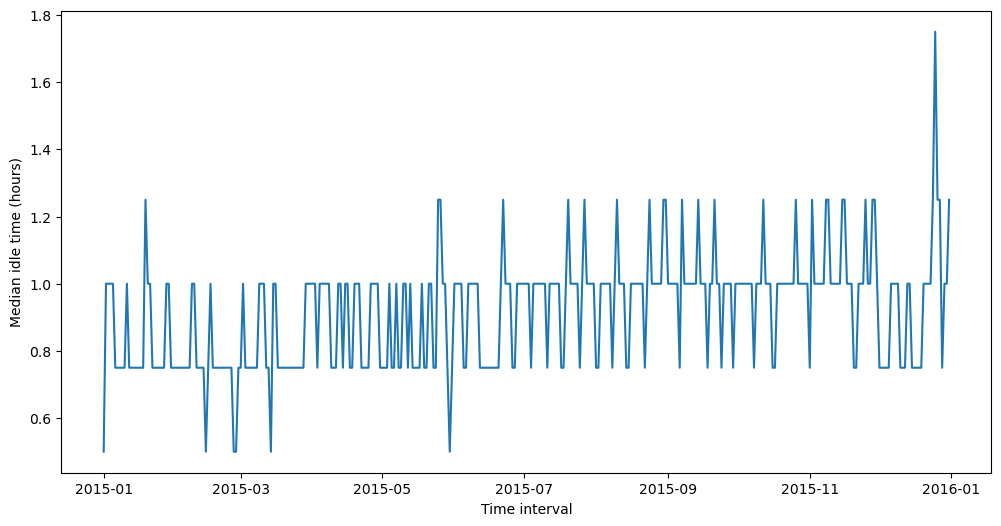

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    trips_with_next.groupby("timeinterval").idle_time.median().dt.total_seconds()
    / 60
    / 60,
)
ax.set_xlabel("Time interval")
ax.set_ylabel("Median idle time (hours)")

plt.show()

With a **visulization type?** we show the median idle time in hours for the one year period. The median idle time is overall very similar. We can see a bigger idle time around December, which could be attributed to holiday-related changes in travel demand. Additionally other short peaks during June to November csn be seen, possibly due to seasonal events or factors influencing travel behavior, and one around February, likely related to weather conditions. 
Around January to March smaller idle times can be seen, this phenomenon can be attributed to the colder weather prevalent in Chicago during this period. Around June a smaller idle time can also be observed. Conversely, in June, a reduction in idle time is discernible. This trend can be attributed to the onset of warmer weather, likely leading to more outdoor activities and higher demand for transportation services, thus reducing taxi idle times during this period.

In [58]:
trips_with_next.head()

taxi_id trip_start_timestamp  trip_end_timestamp  trip_seconds  \
37       12  2015-01-01 00:30:00 2015-01-01 00:45:00         540.0   
48       32  2015-01-01 00:30:00 2015-01-01 00:30:00          60.0   
49        8  2015-01-01 00:30:00 2015-01-01 00:45:00         240.0   
84       21  2015-01-01 00:30:00 2015-01-01 00:45:00         960.0   
88       72  2015-01-01 00:30:00 2015-01-01 00:45:00         360.0   

    trip_miles  pickup_census_tract  dropoff_census_tract  \
37         1.6          17031320100           17031081700   
48         0.6          17031062700           17031062800   
49         0.6          17031070400           17031070300   
84         5.4          17031061500           17031010502   
88         0.6          17031081700           17031081500   

    pickup_community_area  dropoff_community_area   fare  ...  \
37                     32                       8   7.25  ...   
48                      6                       6   4.45  ...   
49                      7                       7   4.45  ...   
84                      6                       1  14.25  ...   
88                      8                       8   5.45  ...   

    h3_09_dropoff_next                pickup_centroid_next  \
37     892664c1e2fffff  POINT (-87.618868355 41.890922026)   
48     892664c1e33ffff  POINT (-87.665676837 41.928763006)   
49     892664c1293ffff  POINT (-87.651562592 41.936310131)   
84     892664c160fffff  POINT (-87.668794439 41.945170453)   
88     892664c1e73ffff  POINT (-87.640901525 41.907412816)   

                 dropoff_centroid_next  datetime_next temp_next precip_next  \
37  POINT (-87.620992913 41.884987192)     2015-01-01   -7.0115         0.0   
48  POINT (-87.618868355 41.890922026)     2015-01-01   -7.0115         0.0   
49  POINT (-87.661265218 41.936159071)     2015-01-01   -7.0115         0.0   
84  POINT (-87.661545096 41.945282331)     2015-01-01   -7.0115         0.0   
88   POINT (-87.63186395 41.892042136)     2015-01-01   -7.0115         0.0   

    pickup_name_next  dropoff_name_next       idle_time  timeinterval  
37   Near North Side               Loop 0 days 00:15:00    2015-01-01  
48      Lincoln Park    Near North Side 0 days 00:00:00    2015-01-01  
49         Lake View          Lake View 0 days 00:15:00    2015-01-01  
84         Lake View          Lake View 0 days 00:15:00    2015-01-01  
88   Near North Side    Near North Side 0 days 00:15:00    2015-01-01  

[5 rows x 93 columns]

In [59]:
trips_with_next['month'] = trips_with_next.trip_start_timestamp.dt.month

In [60]:
idle_by_hex7_time_median = trips_with_next.groupby(["h3_07_pickup_next", "month"])[
    "idle_time"
].median().rename("idle_time_median")
idle_by_hex7_time_mean = trips_with_next.groupby(["h3_07_pickup_next", "month"])[
    "idle_time"
].mean().rename("idle_time_mean")

idle_by_hex7_time = pd.concat(
	[idle_by_hex7_time_median, idle_by_hex7_time_mean], axis=1
).reset_index()

In [61]:
idle_by_hex7_time["idle_time_median_days"] = (
    idle_by_hex7_time["idle_time_median"].dt.total_seconds() / 60 / 60 / 24
)
idle_by_hex7_time["idle_time_mean_days"] = (
    idle_by_hex7_time["idle_time_mean"].dt.total_seconds() / 60 / 60 / 24
)

In [62]:
idle_by_hex7 = idle_by_hex7_time.groupby("h3_07_pickup_next").mean().reset_index()

/var/folders/9w/m9xdz1rs3gb300n40q8vf0fm0000gq/T/ipykernel_77970/2469327571.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [63]:
idle_by_hex7.rename(columns={"h3_07_pickup_next":"hex"}, inplace=True)
idle_by_hex7_time.rename(columns={"h3_07_pickup_next":"hex"}, inplace=True)

In [64]:
import math

idle_by_hex7['month'] = idle_by_hex7['month'].astype(int)

idle_by_hex7.head()

hex  month  idle_time_median_days  idle_time_mean_days
0  872664196ffffff     10               0.062500             0.062500
1  872664520ffffff      1               0.255208             0.255208
2  872664521ffffff      6               0.076389             0.212067
3  872664523ffffff      2               0.312500             0.312500
4  872664525ffffff      5               0.750579             0.787809

In [65]:
idle_by_hex7['geometry'] = (idle_by_hex7.apply(add_geometry,axis=1)) 
idle_by_hex7_time['geometry'] = (idle_by_hex7.apply(add_geometry,axis=1)) 

In [66]:
idle_by_hex7_time['geometry'].isna().sum()
idle_by_hex7_time = idle_by_hex7_time.dropna(axis=0)
idle_by_hex7_time

hex  month idle_time_median            idle_time_mean  \
0   872664196ffffff      9  0 days 02:00:00           0 days 02:00:00   
1   872664196ffffff     12  0 days 01:00:00           0 days 01:00:00   
2   872664520ffffff      1  0 days 06:07:30           0 days 06:07:30   
3   872664521ffffff      1  0 days 02:00:00 0 days 05:13:37.676814553   
4   872664521ffffff      2  0 days 01:45:00 0 days 04:55:06.859912843   
..              ...    ...              ...                       ...   
85  872664c14ffffff      1  0 days 01:15:00 0 days 03:00:21.353558926   
86  872664c14ffffff      2  0 days 01:15:00 0 days 02:46:32.158968850   
87  872664c14ffffff      3  0 days 01:15:00 0 days 02:43:24.437154696   
88  872664c14ffffff      4  0 days 01:15:00 0 days 02:42:50.218858662   
89  872664c14ffffff      5  0 days 01:15:00 0 days 02:45:06.655948553   

    idle_time_median_days  idle_time_mean_days  \
0                0.083333             0.083333   
1                0.041667             0.041667   
2                0.255208             0.255208   
3                0.083333             0.217797   
4                0.072917             0.204941   
..                    ...                  ...   
85               0.052083             0.125247   
86               0.052083             0.115650   
87               0.052083             0.113477   
88               0.052083             0.113081   
89               0.052083             0.114660   

                                             geometry  
0   POLYGON ((-87.57790900980412 41.70504686248289...  
1   POLYGON ((-87.78295871707687 41.80835732039707...  
2   POLYGON ((-87.762037018137 41.79236021148566, ...  
3   POLYGON ((-87.7915048446239 41.787959178667556...  
4   POLYGON ((-87.75347643973124 41.81275804786459...  
..                                                ...  
85  POLYGON ((-87.90424336171452 41.98162357687840...  
86  POLYGON ((-87.81550224456147 41.99494266441130...  
87  POLYGON ((-87.84509050524235 41.99050999827375...  
88  POLYGON ((-87.82796513124613 42.03141983182144...  
89  POLYGON ((-87.80692886821576 42.01539487277240...  

[90 rows x 7 columns]

In [67]:
idle_by_hex7 = idle_by_hex7.sort_values('month')

variable = "idle_time_median_days"

fig = plot_frequency(
    dataset=idle_by_hex7,
    variable=variable,
    labels={variable: "Idle Time in Res7"},
    range_color=(0, idle_by_hex7[variable].quantile(0.9)),
    palette="reds",

)

fig.show()

### Noch in Res 8 und 9 machen 

It can be observed that there is a higher idle time around periheral areas in Chicago, possibily due to the patterns that were seen in the starting and ending trips, as well as demand difference, where it was visible that there is little demand for Taxis. 
**Explain why there are no idle times? Unten links keine Einzeichnungen von hex's** 